In [92]:
import time
import json
import os

import pandas as pd
import numpy as np
import networkx as nx
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

import stellargraph as sg
from stellargraph import datasets
from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE, Dense

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

import run

v_sets, e_sets, core_sample, ext_sample, v_sample, e_sample = run.main()

Running the scripts sequentially 

LOADING DATA: 13.90 s
SUBSAMPLING: 0.05 s
PREPROCESSING: Complete in 0.04 s


In [3]:
g = sg.StellarGraph(v_sets, e_sets)
print(g.info())

StellarGraph: Undirected multigraph
 Nodes: 19011, Edges: 10000

 Node types:
  Account: [11035]
    Features: float32 vector, length 3
    Edge types: Account-has account->Customer, Account-money transfer->Account, Account-money transfer->Derived Entity
  Customer: [3349]
    Features: float32 vector, length 5
    Edge types: Customer-has account->Account, Customer-has address->Address, Customer-is similar->External Entity
  Derived Entity: [3055]
    Features: float32 vector, length 4
    Edge types: Derived Entity-is similar->External Entity, Derived Entity-money transfer->Account
  External Entity: [1148]
    Features: float32 vector, length 4
    Edge types: External Entity-is similar->Customer, External Entity-is similar->Derived Entity
  Address: [424]
    Features: float32 vector, length 2
    Edge types: Address-has address->Customer

 Edge types:
    Account-money transfer->Account: [3277]
        Weights: range=[1, 500], mean=180.168, std=223.482
        Features: none
    A

In [17]:
walk_length = 10  # maximum length of a random walk to use throughout this notebook

# specify the metapath schemas as a list of lists of node types.
metapaths = [
    ["Account", "Account"],
    ["Account", "Derived Entity", "Account"],
    ["Derived Entity", "Account", "Derived Entity"],
    ["Account", "Account", "Account"],
    ["Account", "Account", "Account", "Account"]
]

In [18]:
from stellargraph.data import UniformRandomMetaPathWalk

trw = time.time()

# Create the random walker
rw = UniformRandomMetaPathWalk(g)

walks = rw.run(
    nodes=list(g.nodes()),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
trw1 = time.time()

print("Number of random walks: {} in {:.2f} s".format(len(walks), (trw1-trw)))

Number of random walks: 471950 in 622.80 s


In [19]:
from gensim.models import Word2Vec
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=8, iter=5)

In [20]:
# Retrieve node embeddings 
node_ids = model.wv.index2word  # list of node IDs
node_embeddings = (model.wv.vectors)  # numpy.ndarray of size number of nodes times embeddings dimensionality

# extract targets from vertices' data
core_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].CoreCaseGraphID
ext_targets = v_sample.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID

In [21]:
model.wv.vectors.shape

(14090, 128)

In [22]:
ext_targets.shape

(14090,)

In [26]:
transform = TSNE  # PCA

ttsne = time.time()
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)
ttsne1 = time.time()
print(f"Done in {(ttsne1-ttsne):.2f} s")

Done in 95.18 s


In [27]:
node_embeddings_2d.shape

(14090, 2)

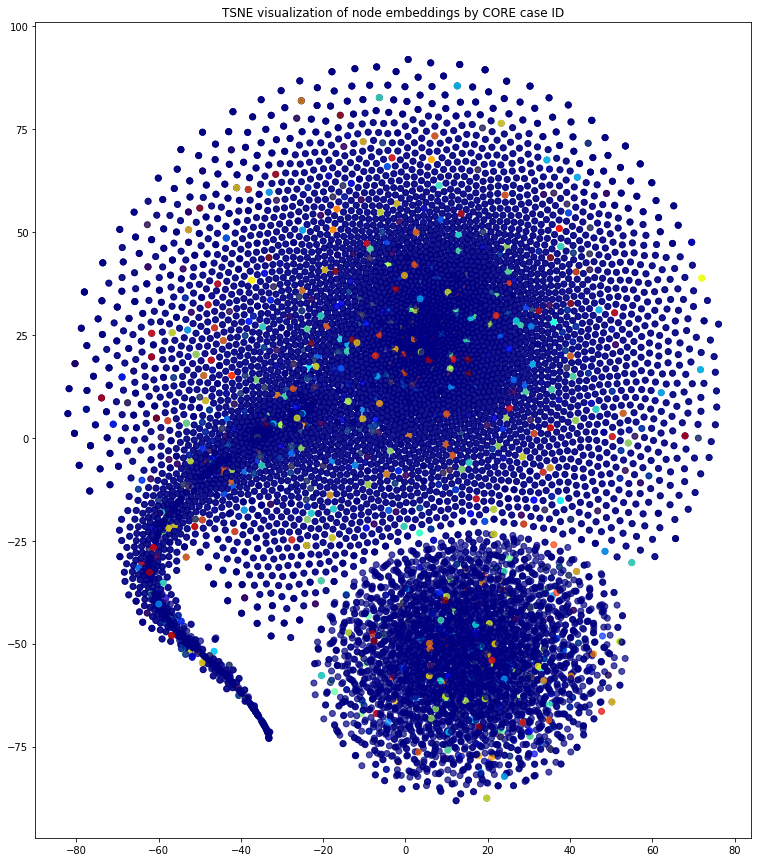

In [100]:
# draw the points
label_map = {l: i for i, l in enumerate(np.unique(core_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in core_targets]

plt.figure(figsize=(15, 15))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0], 
    node_embeddings_2d[:, 1], 
    c=node_colours,
    cmap="jet",
    alpha=0.7)

plt.title("{} visualization of node embeddings by CORE case ID".format(transform.__name__))
plt.show()

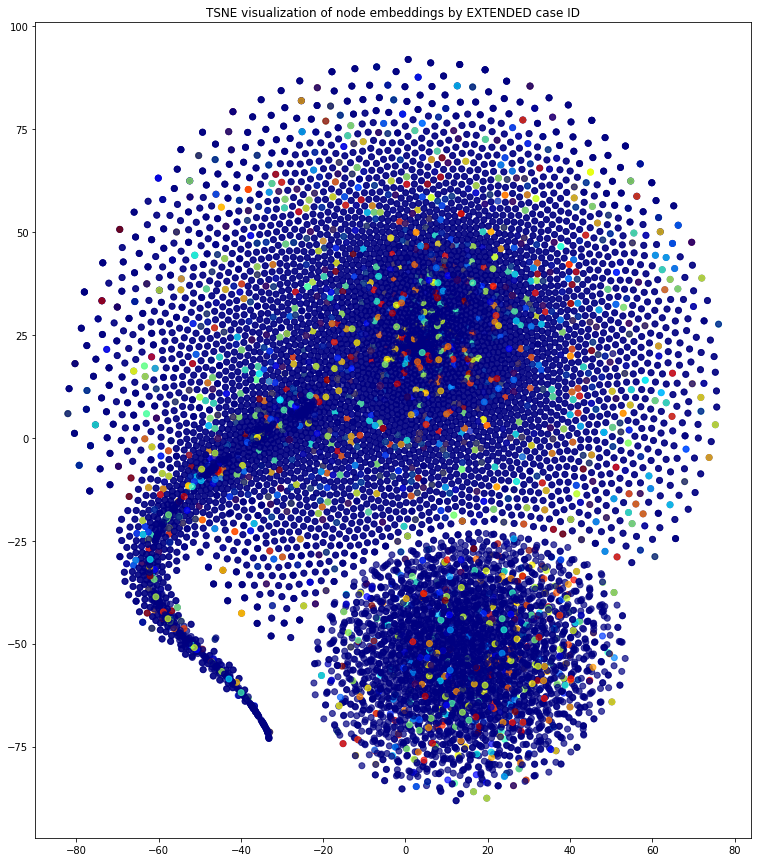

In [101]:
label_map = {l: i for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours = [label_map[target] if pd.notna(target) else 0 for target in ext_targets]

plt.figure(figsize=(15, 15))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0], 
    node_embeddings_2d[:, 1], 
    c=node_colours,
    cmap="jet",
    alpha=0.7)

plt.title("{} visualization of node embeddings by EXTENDED case ID".format(transform.__name__))
plt.show()

In [33]:
os.system('say "Ho finito di calcolare"')

0

In [91]:
# This really is not a good embedding...

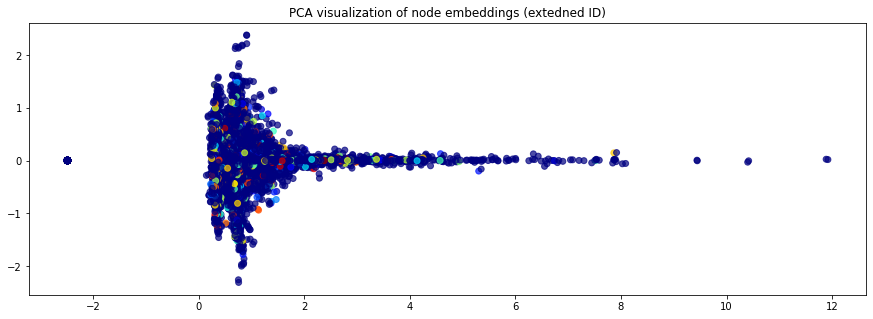

In [102]:
trans2 = PCA(n_components=2)
node_embeddings_2d_2 = trans2.fit_transform(node_embeddings)

# draw the points
label_map_2 = {l: i for i, l in enumerate(np.unique(ext_targets), start=10) if pd.notna(l)}
node_colours_2 = [label_map_2[target] if pd.notna(target) else 0 for target in ext_targets]

plt.figure(figsize=(15, 15))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d_2[:, 0], 
    node_embeddings_2d_2[:, 1], 
    c=node_colours_2,
    cmap="jet",
    alpha=0.7)

plt.title("PCA visualization of node embeddings (extedned ID)")
plt.show()
